<h1><center>Feature Importance</center></h1>

<h2><center>By Alex Bradshaw</center></h2>


# 1. Introduction
   Feature importance is how important our features are (duh), but what does that really mean and why does it matter? Specifically, it means what features actually have significant power predicting our target variable. If a red ball bounced more than a blue ball, would we conclude red balls generally bounce higher than blue ones? Maybe for this example but it doesn't generalize well, and it's more important to generalize well than to be correct for any specific situation. In the real world, we would add as many features as possible at first into a model, and then select which ones generalize the best for unknown data. 

## 2. Adding "Noise"
My personal favorite feature importance method is by adding random noise. This technique is usually best used in random forest models since its feature importance attribute isn't inherently meaniningful. The idea behind this method is that the noise feature will get assigned some feature importance value. Since it's literally random mumbo jumbo, we know that it should not predict very well at all. Therefore anything given an importance value less than it we should exclude. Here's an example:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
def run_forest_run(X, y, rf=RandomForestRegressor(random_state=13)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)
    X_train['noise'] = np.random.choice(np.arange(10), size = len(X_train))
    rf.fit(X_train, y_train)
    arr = [(rf.feature_names_in_[x], rf.feature_importances_[x]) for x in range(len(rf.feature_importances_))]
    feats = np.array(sorted(arr, key=lambda x: x[1], reverse=True))
    return feats

In [3]:
X, y = sk.fetch_california_housing(as_frame=True, return_X_y=True)
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


/var/folders/dc/vmrx_nc16tz65xmfmz0x56kh0000gn/T/ipykernel_6430/1392914790.py:6: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


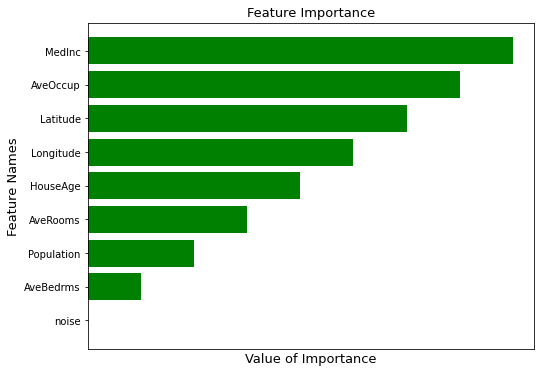

In [4]:
feats = run_forest_run(X, y)
names = list(feats[:, 0])
names.reverse()
plt.figure(figsize=(8, 6))
plt.barh(names, feats[:, 1], color = 'green')
plt.xticks([])
plt.title('Feature Importance', size=13)
plt.xlabel('Value of Importance', size=13)
plt.ylabel('Feature Names', size=13)
plt.show()

### Summary:
As we can see here, most of our values did better than random noise but that's not always the case. In the event our data is absolutely atrocious, noise has a possibility to be our highest predictor. In reality that usually isn't the case but it theorhetically could happen. 

What about the values that do slightly better than noise? We can concretely say values that did worse than randomly picking are not good at predicting, but where do we draw the line between bad and good? Well we can just try a different feature importance method and see if it lines up.

## 3 Feature Permutation
This is my next favorite feature importance method because it's really easy to implement and understand. We run a regression with each column and our target variable, and then do it again with our feature indices shuffled. The theory behind it is that if the feature is important, shuffling around its data will vastly ruin the results. Vice versa, if a feature is not very important, shuffling its data around may not change the result much. It's important to use a good metric or model here that captures the relationship between your features and your target variable. For example, using mean absolute error with values on very different scales may lead to some incorrect conclusions. To avoid this I simply standardized both sides. Here is a sample implementation below.

In [5]:
feats = []
y_std = stats.zscore(y)
for c in X.columns:
    X_std = stats.zscore(X[c])
    mse = mean_squared_error(X_std, y_std)
    mse_shuffled = mean_squared_error(X_std.sample(frac=1, random_state=171), y_std)
    feats.append([c, mse, mse_shuffled, mse_shuffled-mse])
print('Features Ranked by Drop in MSE:\n')
for c in sorted(feats, key=(lambda x: x[3]), reverse=True):
    print(f'Feature: {c[0]}')
    print(f'Original MSE: {c[1]}')
    print(f'Shuffled MSE: {c[2]}\n')

Features Ranked by Drop in MSE:

Feature: MedInc
Original MSE: 0.623849584082904
Shuffled MSE: 1.9978189555233081

Feature: AveRooms
Original MSE: 1.6961034205170844
Shuffled MSE: 1.9776063713524719

Feature: HouseAge
Original MSE: 1.7887531750135799
Shuffled MSE: 1.9957984013922356

Feature: AveOccup
Original MSE: 2.0474748259122686
Shuffled MSE: 2.011435022622182

Feature: Population
Original MSE: 2.0492993577777896
Shuffled MSE: 2.0106582610717116

Feature: Longitude
Original MSE: 2.0919332302359566
Shuffled MSE: 2.01641903994245

Feature: AveBedrms
Original MSE: 2.093401025938974
Shuffled MSE: 1.9895411428871816

Feature: Latitude
Original MSE: 2.2883205537493185
Shuffled MSE: 1.982975541345169



### Summary:
According to this list, we have some features that are not as important as we thought and now we have some features that did better when we shuffled around their indices. This would imply they're not very important or we just got unlucky and the indices created a fictional correlation. Aside from MedInc, its not clear how much (if any) significance the other features have in predicting our target or more importantly, we're not sure which features we should use as a final model to predit our target variable. 

## 4 Linear Regression p-values



Another method of feature importance is very simply, looking at the p-values when doing a linear regression. The way I like to think about p-values is the probability that the corresponding variable is not significant. This is because it's calculated using a t-test which compares the sum of squared residuals when the coefficient of the feature is zero versus it being non-zero. The typical p-value border is 0.05. If something has a p-value below 0.05, it's significant and if its above its not. Here's an example with our data:


In [6]:
string = ''
for c in X.columns:
    string += c + '+'
string = string[:-1]
Xy = X.copy()
Xy['target'] = y
lr = smf.ols(f'target ~ {string}', data=Xy).fit()
Xy.drop('target', axis=1, inplace=True)
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     3970.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        18:20:44   Log-Likelihood:                -22624.
No. Observations:               20640   AIC:                         4.527e+04
Df Residuals:                   20631   BIC:                         4.534e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -36.9419      0.659    -56.067      0.000     -38.233     -35.650
MedInc         0.4367      0.004    104.054      0.000       0.428       0.445
HouseAge       0.0094      0.000     21.143      0.000       0.009       0.010
AveRooms      -0.1073      0.006    -18.235      0.000      -0.119      -0.096
AveBedrms      0.6451      0.028     22.928      0.000       0.590       0.700
Population -3.976e-06   4.75e-06     -0.837      0.402   -1.33e-05    5.33e-06
AveOccup      -0.0038      0.000     -7.769      0.000      -0.005      -0.003
Latitude      -0.4213      0.007    -58.541      0.000      -0.435      -0.407
Longitude     -0.4345      0.008    -57.682      0.000      -0.449      -0.420
==============================================================================
Omnibus:                     4393.650   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14087.596
Skew:                           1.082   Prob(JB):                         0.00
Kurtosis:                       6.420   Cond. No.                     2.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In our linear regression model summary, it tells us that in fact all of our variables are significant except for Population. This adds up with our initial feature selection methods because Population is always at the bottom and MedInc is always at the top.

## 5 Summary
Although there definitely is more ways to find important features, these are three quick and easy methods to find which features significantly predict unseen data accurately. The reason there might be some variation from method to method or why some features may not seem as important as you think they should be using domain knowledge for instance, is because the data might be missing important features or two or more features are highly correlated which might bring both of their individual importances down even though they may both be important. Fixing this would be more of a feature engineering issue than feature importance which is why I did not cover it in this notebook. Overall, it's impossible to know the ground truth of feature combinations that actually make up our data so using different methods of feature importance is important to learn more about our data and use that information to make the best model that will predict unseen data.
